In [8]:
import pandas as pd
from datetime import datetime

import numpy as np

import matplotlib.pylab as plt
%matplotlib inline

from tqdm import tqdm, tqdm_notebook
pd.set_option("display.max_rows", 100)
pd.set_option('display.max_columns', 200)

from sklearn.linear_model import LinearRegression, ElasticNet, Ridge
fname = 'data.csv'

def init_data(fname):
    data = pd.read_csv('data.csv')
#     data.xprice = (data.xprice - data.xprice.min()) #/ data.xprice.std() 
#     data.yprice = (data.yprice - data.yprice.min()) #/ data.yprice.std() 
    data['timestamp'] = data['timestamp'] // 1000
    data.timestamp = data.timestamp.apply(lambda stamp: datetime.fromtimestamp(stamp))
    data.timestamp = data.timestamp - pd.Timedelta(hours=1) # for flexibility
    data['weekday'] = data.timestamp.dt.weekday
    data['day'] = (data.timestamp.dt.date - data.timestamp.dt.date.min()).apply(lambda x: int(x.days))
    day_close_time = data.day.map(data.groupby('day').timestamp.max())
    data['periods_before_closing'] = (day_close_time - data.timestamp).apply(lambda x: x.seconds // 10) 
    return data
    
def time_split(data, valid_ratio, test_ratio):
    n_valid = max(1, int(data.shape[0] * valid_ratio))
    n_test = max(1, int(data.shape[0] * test_ratio))
    n_train = data.shape[0] - n_valid - n_test
    
    train = data.iloc[:n_train].reset_index(drop=True).copy()
    valid = data.iloc[n_train:-n_test].reset_index(drop=True).copy()
    test = data.iloc[-n_test:].reset_index(drop=True).copy()
    merged_test = valid.append(test).reset_index(drop=True)
    print('Data shapes: ', train.shape, valid.shape, test.shape)
    return train, valid, test

In [9]:
def add_diffs(df, column, uselags):
    new_columns = []
    for lag in uselags:
        colname = '{}_diff_{}'.format(column, lag)
        df.loc[:, colname] = df[column].diff(lag)
        new_columns.append(colname)
    print(new_columns)
    return new_columns

def add_shifts(df, column, uselags):
    new_columns = []
    for lag in uselags:
        colname = '{}_lag_{}'.format(column, lag)
        df.loc[:, colname] = df[column].shift(lag)
        new_columns.append(colname)
    print(new_columns)
    return new_columns

def add_norm(df, column):
    colname = '{}_norm'.format(column)
    df.loc[:, colname] = (df[column] - df[column].mean()) / df[column].std()
    return colname

def add_rolling_mean(df, column, windows):
    new_columns = []
    for window_size in windows:
        colname = '{}_ma_{}'.format(column, window_size)
        df.loc[:, colname] = df[column].rolling(window=window_size).mean()
        new_columns.append(colname)
    print(new_columns)
    return new_columns

def add_curstom_rolling_operation(df, column, agg_function, function_name, windows):
    new_columns = []
    for window_size in windows:
        colname = '{}_{}_{}'.format(column, function_name, window_size)
        df.loc[:, colname] = df[column].rolling(window=window_size).agg(agg_function)
        new_columns.append(colname)
    print(new_columns)
    return new_columns  

def rsiFunc(prices, n=14):
    deltas = np.diff(prices)
    seed = deltas[:n+1]
    up = seed[seed>=0].sum()/n
    down = -seed[seed<0].sum()/n
    rs = up/down
    rsi = np.zeros_like(prices)
    rsi[:n] = 100. - 100./(1.+rs)

    for i in range(n, len(prices)):
        delta = deltas[i-1] # cause the diff is 1 shorter

        if delta>0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta

        up = (up*(n-1) + upval)/n
        down = (down*(n-1) + downval)/n

        rs = up/down
        rsi[i] = 100. - 100./(1.+rs)

    return rsi

def add_rsi(df, column, windows):
    new_columns = []
    for window_size in windows:
        colname = '{}_rsi_{}'.format(column, window_size)
        df.loc[:, colname] = rsiFunc(df[column].values, window_size)
        new_columns.append(colname)
    print(new_columns)
    return new_columns  

def add_ewma(df, column, windows):
    new_columns = []
    for window_size in windows:
        colname = '{}_ewma_{}'.format(column, window_size)
        df.loc[:, colname] = pd.Series.ewm(df[column], span=window_size).mean()
        new_columns.append(colname)
    print(new_columns)
    return new_columns 



In [10]:
def add_relation_features(df, ycol='yprice', xcol='xprice'):
    df['yx_sub'] = df[ycol] - df[xcol]
    df['yx_divided'] = df[ycol] / df[xcol]
    df['xy_divided'] = df[xcol] / df[ycol]
    new_cols = ['yx_sub', 'yx_divided', 'xy_divided']
    return new_cols

def add_hand_feats(df):
    close_price_per_day = df.groupby('day').timestamp.max().shift(1).map(
        df[['timestamp', 'yprice']].set_index('timestamp').yprice)
    df.loc[:, 'ydiff_from_closing'] = (df.day.map(close_price_per_day) - df.yprice).fillna(0)
    close_price_per_day = df.groupby('day').timestamp.max().shift(1).map(
        df[['timestamp', 'xprice']].set_index('timestamp').xprice)
    df.loc[:, 'xdiff_from_closing'] = (df.day.map(close_price_per_day) - df.yprice).fillna(0)
    
    open_price_per_day = df.groupby('day').timestamp.min().map(
        df[['timestamp', 'yprice']].set_index('timestamp').yprice)
    df.loc[:, 'ydiff_from_opening'] = (df.day.map(open_price_per_day) - df.yprice)
    
    open_price_per_day = df.groupby('day').timestamp.min().map(
        df[['timestamp', 'xprice']].set_index('timestamp').xprice)
    df.loc[:, 'xdiff_from_opening'] = (df.day.map(open_price_per_day) - df.xprice)
    new_columns = ['ydiff_from_closing', 'xdiff_from_closing', 'ydiff_from_opening', 'xdiff_from_opening']
    print(new_columns)
    return new_columns

In [11]:
data = init_data(fname)
data.head()

,timestamp,xprice,yprice,returns,weekday,day,periods_before_closing
0,2013-01-03 20:05:00,139.8375,169.2500,0.3125,3,0,1409
1,2013-01-03 20:05:10,139.8875,169.3000,0.2750,3,0,1408
2,2013-01-03 20:05:20,139.8625,169.3375,0.2500,3,0,1407
3,2013-01-03 20:05:30,139.8375,169.3625,0.2375,3,0,1406
4,2013-01-03 20:05:40,139.8375,169.3625,0.3250,3,0,1405


In [5]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

standart_calendar_lags = [6, 60, 360, 1410, 7050, 14100, 28200, 42300]
qazy_calendar_lags = [6, 60, 360, 720, 1410, 2820, 7050, 14100, 28200, 42300]
day_lags = 1410 * np.arange(1, 75)
valid_ratio = 0.1
test_ratio = 0.1

In [13]:
add_relation_features(data)

['yx_sub', 'yx_divided', 'xy_divided']

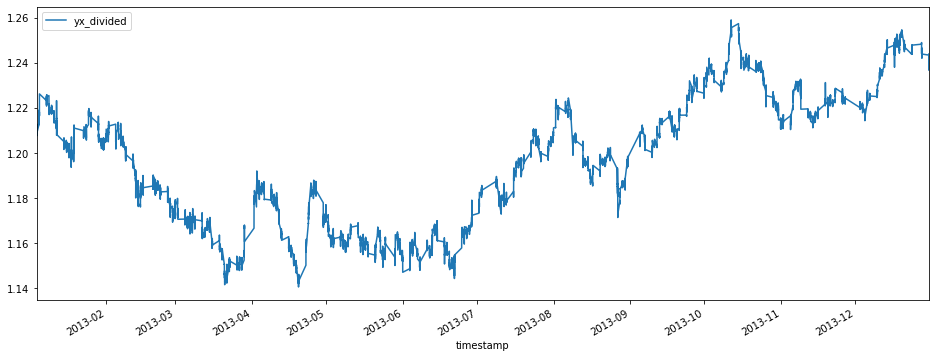

In [17]:
# data.returns.plot(figsize=(16,6))
data.set_index('timestamp').yx_divided.plot(figsize=(16,6))
plt.legend(loc='best')
plt.show()

In [20]:
data = pd.read_csv('data.csv')
plt.figure(figsize=(22,10))
plt.plot((data.yprice.resample('60S').min()) / (data.xprice.resample('60S').min()) )

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'RangeIndex'

<Figure size 1584x720 with 0 Axes>

In [30]:
data = pd.read_csv('data.csv')
data['timestamp'] = data['timestamp'] // 1000
data.timestamp = data.timestamp.apply(lambda stamp: datetime.fromtimestamp(stamp))
data.timestamp = data.timestamp - pd.Timedelta(hours=1) # for flexibility
data.index = data.timestamp
data.head()

,timestamp,xprice,yprice,returns
timestamp,,,,
2013-01-03 20:05:00,2013-01-03 20:05:00,139.8375,169.2500,0.3125
2013-01-03 20:05:10,2013-01-03 20:05:10,139.8875,169.3000,0.2750
2013-01-03 20:05:20,2013-01-03 20:05:20,139.8625,169.3375,0.2500
2013-01-03 20:05:30,2013-01-03 20:05:30,139.8375,169.3625,0.2375
2013-01-03 20:05:40,2013-01-03 20:05:40,139.8375,169.3625,0.3250


In [32]:
data.yprice.resample('60S').min()

timestamp
2013-01-03 20:05:00    169.2500
2013-01-03 20:06:00    169.2750
2013-01-03 20:07:00    169.2750
2013-01-03 20:08:00    169.3375
2013-01-03 20:09:00    169.3375
                         ...   
2013-12-30 23:55:00    167.9500
2013-12-30 23:56:00    167.9375
2013-12-30 23:57:00    167.9250
2013-12-30 23:58:00    167.9250
2013-12-30 23:59:00    167.8500
Freq: 60S, Name: yprice, Length: 520075, dtype: float64

In [ ]:
plt.figure(figsize=(22,10))
plt.plot((data.yprice.resample('60S').min()) / (data.xprice.resample('60S').min()) )